# Building DNN Models for Regression with TensorFlow core

### Importing the libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%matplotlib inline

## 1. Load and prepare the data

In [2]:
from pandas import read_csv
from sklearn.model_selection import train_test_split

current_dir = os.getcwd()
dataset_path = os.path.join(os.getcwd(), os.pardir,'data','diamond_prices.csv')
diamonds = read_csv(dataset_path)
TARGET = 'price'
X_data = diamonds.iloc[:,1:].values
y_data = diamonds[TARGET].values

## Separating into training and testing
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, train_size=0.95, random_state=12)

## 2. Build the input pipeline

In [3]:
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(BATCH_SIZE)
iterator = train_dataset.make_initializable_iterator()
next_element = iterator.get_next()

## 3. Build a function containing the DNN

In [4]:
n_hidden1 = 128
n_hidden2 = 64
n_hidden3 = 32
n_hidden4 = 16
n_outputs = 1

def DNN(inputs):
    wt_init = tf.contrib.layers.xavier_initializer()
    hidden1 = tf.layers.dense(inputs, units=n_hidden1, activation=tf.nn.relu, 
                              kernel_initializer=wt_init)
    hidden2 = tf.layers.dense(hidden1, units=n_hidden2, activation=tf.nn.relu, 
                              kernel_initializer=wt_init)
    hidden3 = tf.layers.dense(hidden2, units=n_hidden3, activation=tf.nn.relu, 
                              kernel_initializer=wt_init)
    hidden4 = tf.layers.dense(hidden3, units=n_hidden4, activation=tf.nn.relu, 
                              kernel_initializer=wt_init)
    
    y_pred = tf.layers.dense(hidden4, units=n_outputs, activation=None)
    return tf.squeeze(y_pred)

## 4. Create the placeholders to pass values for training and evaluation

In [5]:
n_inputs = X_data.shape[1] # number of features in the dataset
X = tf.placeholder(tf.float32, shape=[None, n_inputs], name='X')
y = tf.placeholder(tf.float32, name='target')

## 5. Define the loss

In [6]:
y_pred = DNN(X)
mse = tf.losses.mean_squared_error(labels=y, predictions=y_pred)

# Optional:
## Root Mean Squared Error for TensorBoard visualization
rmse = tf.sqrt(mse)
tf.summary.scalar('RMSE', rmse)
## We will also visualize the distribution of the errors the model makes
errors = y_pred - y
tf.summary.histogram('Errors', errors)
## Summary an writer objects for TensorBoard
summary_values = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(os.path.join(current_dir, 'reg_logs','train'))
val_writer = tf.summary.FileWriter(os.path.join(current_dir, 'reg_logs','validation'))

## 6. Define the optimizer and training operation

In [7]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(mse)

## 7. (Optional) Write a function for running the training operation

In [8]:
def train_model(epoch_number):
    """This fuction performs the training operation for one epoch,
    then records metrics for TensorBoard visualization"""
    print(epoch_number, end=',')
    iterator.initializer.run()
    while True:
        try:
            X_values, y_values = sess.run(next_element)
            sess.run(training_op, feed_dict={X: X_values, y:y_values})
        except tf.errors.OutOfRangeError:
            break
    ## Training RMSE (computed  only for the last batch of the epoch)
    summaries = sess.run(summary_values, feed_dict={X:X_values, y:y_values})
    train_writer.add_summary(summaries, epoch_number)
    ## Validation RMSE (for all the validation set)
    summaries = sess.run(summary_values, feed_dict={X:X_val, y:y_val})
    val_writer.add_summary(summaries, epoch_number)

## 8. Run the computation graph

In [9]:
N_EPOCHS = 300
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    train_writer.add_graph(sess.graph)
    
    ## Training loop
    print("Epoch: ")
    for epoch in range(1,N_EPOCHS+1):
        train_model(epoch)
    print("\nDone Training!")
    
    # Closing the file writers
    train_writer.close()
    val_writer.close()
    
    # Getting the predictions for the validation dataset
    predictions = sess.run(y_pred, feed_dict={X: X_val})

Epoch: 
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,

## 9. Visualize/analyze the results of the model

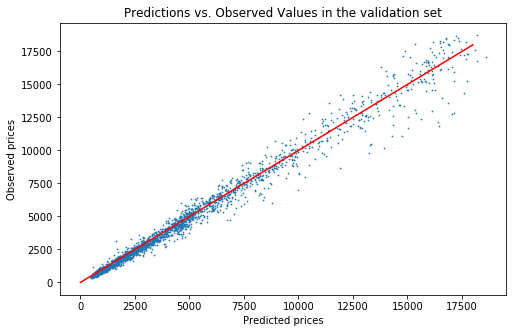

In [10]:
from numpy import linspace
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x=predictions, y=y_val, s=0.5)
x = linspace(0,18000)
ax.plot(x, x,'r')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices')
ax.set_title("Predictions vs. Observed Values in the validation set");

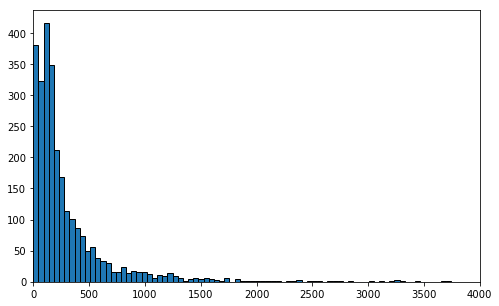

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(abs(y_val-predictions), bins=100, edgecolor='black')
ax.set_xlim(0, 4e3);